In [29]:
import os 
import numpy as np 
import cv2
from pdf2image import convert_from_path
import pytesseract
import unicodedata
import re
import pandas as pd
import natsort
import matplotlib.pyplot as plt
import spellchecker
import rapidfuzz
import unidecode 
import tqdm 

pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'
config = '--oem 2'
spell = spellchecker.SpellChecker(language='fr') # SpellChecker en français

current_dir = os.getcwd()


pd.set_option("display.max_rows", None)      # Show all rows
pd.set_option("display.max_columns", None)   # Show all columns
pd.set_option("display.width", 0)            # Auto-detect width
pd.set_option("display.max_colwidth", None)  # Don't truncate column content


In [2]:
# Extracts the year from the filename after 'Thèses_'.
def extract_year_from_filename(filename):
    # Regex pattern to match both formats
    match = re.search(r'Theses_(\d{4})(?:_(\d{4}))?_(\d+)_(\d+|blank)(?:\.pdf)?$', filename)
    
    # If no match is found, return None or handle as needed
    if not match:
        return None

    # Extract the year and check if there's a second year
    year = match.group(1)
    second_year = match.group(2)  # This will be None if there's no second year
    start = match.group(3)
    end = match.group(4)

    # If a second year exists, concatenate it with the first year
    if second_year:
        year = f"{year}_{second_year}"

    return (year, int(start), end)

In [3]:
#Checks if a page is blank 
def is_blank(image, threshold=0.99):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    height = gray.shape[0]
    
    # Crops the 10% at the bottom of the page so that the number of the page doesn't affect our analysis
    cropped_gray = gray[:int(0.9 * height), :]
    
    _, thresh = cv2.threshold(cropped_gray, 240, 255, cv2.THRESH_BINARY)
    white_ratio = np.sum(thresh == 255) / thresh.size
    
    return white_ratio > threshold  # Retourne True si la page est blanche

In [4]:
# Converts a PDF file into images, saving each page as a PNG.
# # Images are stored in the specified output folder.
def convert_pdf_to_images(pdf_path, output_folder, start_page, end_page):
    images = convert_from_path(pdf_path)
    if end_page =='blank' :
        images = images[start_page:] 
    else : 
        end_page = int(end_page)
        images = images[start_page:end_page+1]  

    for i, image in enumerate(images):
        image_path = os.path.join(output_folder, f"page_{i+1}.png")
        image.save(image_path, "PNG")

        if is_blank(image):
            break

In [5]:
# Processes all PDFs in the input directory.
# Extracts the year from the filename and creates a subfolder for each year.
# Converts each PDF into images and stores them in the corresponding subfolder.
def process_all_pdfs(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Ensure the parent directory exists
    
    for filename in os.listdir(input_dir):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(input_dir, filename)  # Full path to PDF
            year, start_page, end_page = extract_year_from_filename(filename)
            if not year or year == "Erreur":  # Skip if invalid year extracted
                continue

            output_folder = os.path.join(output_dir, year)
            os.makedirs(output_folder, exist_ok=True)  # Ensure the subfolder is created
            
            convert_pdf_to_images(pdf_path, output_folder,start_page,end_page)



In [85]:
# Define the input and output paths relative to the current directory
input_dir = os.path.join(current_dir, '..', 'data', 'pdf_Tables_theses_Paris_1870_1939')  # Relative path to 'lib/data/pdf_Tables_theses_Paris_1870_1939'
output_dir = os.path.join(current_dir, '..', 'data', 'pdfs_en_images_png')  # Output path within 'lib/data/pdfs_en_images_png'

os.makedirs(output_dir, exist_ok = True)

process_all_pdfs(input_dir, output_dir)

FIN DE LA TRANSFORMATION EN PNG DES FICHIERS;
DEBUT DE L'EXTRACTIION ET DU TRAITEMENT DU TEXTE.

























In [30]:
def detect_all_tome_positions(image):
    data = pytesseract.image_to_data(image, lang='fra', output_type=pytesseract.Output.DICT)
    tome_positions = []

    for i, text in enumerate(data["text"]):
        clean = text.strip().upper()
        if not clean:
            continue
        if clean == "TOME" or re.search(r'\bTOME\s+\w+\b', clean):
            y = data["top"][i]
            h = data["height"][i]
            tome_positions.append((y, h))

    return sorted(tome_positions, key=lambda x: x[0])  # tri par ordre vertical


In [7]:
def split_by_tome_markers(image, positions):
    slices = []
    prev_y = 0

    for y, h in positions:
        cut_y = y + h
        slices.append(image[prev_y:cut_y, :])
        prev_y = cut_y

    # Dernier segment (jusqu'en bas)
    slices.append(image[prev_y:, :])
    return slices

In [32]:
def extract_columns(image):
    (h, w) = image.shape
    left = image[:, :w//2 - 5]
    right = image[:, 5 + w//2:]    

    left_text = pytesseract.image_to_string(left, lang='fra', config=config)
    right_text = pytesseract.image_to_string(right, lang='fra', config=config)
    return re.sub(r'\d+', '', left_text + " " + right_text)


In [9]:
def process_image(image, first):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    if first:
        gray = gray[580:, :]

    tome_positions = detect_all_tome_positions(gray)

    if tome_positions:
        horizontal_slices = split_by_tome_markers(gray, tome_positions)
        full_text = ""

        for i, slice_img in enumerate(horizontal_slices):
            text = extract_columns(slice_img)
            full_text += f"--- Segment {i+1} ---\n{text}\n\n"

        return full_text
    else:
        return extract_columns(gray)
    
    process_image()

In [10]:
def extract_informations(text, year):

    pattern = re.compile(r"([A-ZÉÀÈÙÂÊÎÔÛÄËÏÖÜÇ]{2,}) \(([^)]+)\)\. (.+)?")

    # Initialisation des variables
    data = []
    current_nom = None
    current_prenom = None
    current_sujet = ""        
    current_year = year             

    lines = text.split("\n")

    for line in lines:
        line = line.strip()  
        
        match = pattern.match(line)  

        if match:
            if current_nom is not None:
                data.append([current_nom, current_prenom, current_sujet.strip(),current_year])

            current_nom = match.group(1)
            current_prenom = match.group(2)
            current_sujet = match.group(3) if match.group(3) else ""
        
        else:
            if current_nom is not None:
                current_sujet += " " + line  

    if current_nom is not None:
        data.append([current_nom, current_prenom, current_sujet.strip(), current_year])

    df_cleaned = pd.DataFrame(data, columns=["Nom", "Prénom", "Sujet","year"])

    return df_cleaned

In [11]:
def process_folder(input_dir,year):
    text = ""  
    df = pd.DataFrame()
  
    
    for image_file in natsort.natsorted(os.listdir(input_dir)):
        image_path = os.path.join(input_dir, image_file)
        image = cv2.imread(image_path)
        if image_file.lower().endswith('.png'): 
            if  image_file == "page_1.png" : 
                first = True 
            else : first = False
            text = text + process_image(image, first)
    df = extract_informations(text,year)
    return df

In [12]:
def remove_accents(text):
    if isinstance(text, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', text)
            if unicodedata.category(c) != 'Mn'
        )
    return text

In [13]:
def cleanup_up_subject_column(df) :
    df['Nom'] = df['Nom'].astype(str)
    df['Prénom'] = df['Prénom'].astype(str)
    df['Sujet'] = df['Sujet'].astype(str)
    df['Sujet'] = df['Sujet'].str.replace('- ', '', regex=False)
    df['Sujet'] = df['Sujet'].str.replace(r',?\s*\d+\s*', ' ', regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r'\s+', ' ', regex=True).str.strip() 
    df['Sujet'] = df['Sujet'].str.replace(r"([bcdfghjklmnpqrstvwxyz]) (?=[aeiouy])", r"\1", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"[\"'#%&*\[\]{}<>|\\/^¤§°@=+\~`]", "", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"[•●▪■♦◊¤§°@©®™‰¨«»„”“†‡‚‘’]", " ", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\b[a-zA-Z]\b", "", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\b(TOM|TON|H|U|UVIL|co|tu|ot|mw|vf|En|El|N)\b", "", regex=True, flags=re.IGNORECASE)
    df['Sujet'] = df['Sujet'].str.replace(r"\s*[\.,;:!?]\s*", ". ", regex=True)
    df['Sujet'] = df['Sujet'].str.replace(r"\s+", " ", regex=True).str.strip()
    df['Sujet'] = df['Sujet'].apply(remove_accents)
    df['Prénom'] = df['Prénom'].apply(remove_accents)

In [14]:
def rescue_missing_entries(df):
    """
    Looks for names accidentally merged into the 'Sujet' field,
    and splits them out into new rows.
    """
    rescue_pattern = re.compile(
        r"\b([A-ZÉÀÈÙÂÊÎÔÛÄËÏÖÜÇ]{2,})[ ,]*([A-ZÉÀÈÙÂÊÎÔÛÄËÏÖÜÇa-zéàèùâêîôûäëïöüç\-]+)\)?[ .,-]"
    )

    rescued_rows = []

    for idx, sujet in df["Sujet"].items():
        matches = list(rescue_pattern.finditer(sujet))

        if matches:
            match = matches[0]
            start = match.start()
            rescued_text = sujet[start:]
            original_subject = sujet[:start].strip()

            # Update current row's Sujet
            df.at[idx, "Sujet"] = original_subject

            # Create rescued row
            nom = match.group(1)
            prenom = match.group(2)
            sujet_rescue = rescued_text[len(match.group(0)):].strip()

            rescued_rows.append({
                "Nom": nom,
                "Prénom": prenom,
                "Sujet": sujet_rescue
            })

    if rescued_rows:
        df_rescue = pd.DataFrame(rescued_rows)
        df = pd.concat([df, df_rescue], ignore_index=True)

    return df


In [15]:
def process_all_folders(input_dir) : 
    df= pd.DataFrame(columns=["Nom", "Prénom", "Sujet", "year"])

    for year_folder in natsort.natsorted(os.listdir(input_dir)):
        year_path = os.path.join(input_dir, year_folder) 
        print(year_folder)        
        if os.path.isdir(year_path):  # Check if it's a directory
            df = pd.concat((df, process_folder(year_path, year_folder)), ignore_index= True)
            rescue_missing_entries(df)
            cleanup_up_subject_column(df)

    return df

In [33]:
input_dir = os.path.join(current_dir, '..', 'data', 'test')  # Relative path to 'lib/data/pdfs_en_images_png'

df1 = process_all_folders(input_dir)
print(df1.to_string(max_rows=250, max_cols=210))


1870
1871
              Nom                Prénom                                                                                                                                                                                                                                          Sujet  year
0          ABADIE    Jean-Marie-Charles                                                                                                                                                                                               Etude sur la myopie stationnaire ct progressive.  1870
1         ANDRIEU              Alphonse                                                                                                                                                                                          De anthrax. de ses complicationset de son traitement.  1870
2          ARCHER               Gabriel                                                                                                

FIN  DE L'EXTRACTION DE TEXTE ET CORRECTIONS MINEURES D'OCR. 
DEBUT DU TRAITEMENT DE TEXTE : 
PRECISION ET CORRECTION DE L'OCR (DICTIONNAIRE FRANCAIS ET MEDICAL)
Corriger les mots faux de l ocrisation a l aide des dictionnaires: 
tu pourrais envisager une correction automatique OCR après reconnaissance (spellchecker français + médical).

Exemples de librairies :

pyspellchecker
fuzzywuzzy pour match flous avec ton francais.txt

Une fois que la correction est faire refaire test de precision


In [21]:
input_dir = input_dir = os.path.join(current_dir, '..', 'data', 'Dictionnaires')  # Relative path to 'lib/data/pdfs_en_images_png'

# Chargement + nettoyage du dictionnaire français
with open(os.path.join(input_dir, 'francais.txt'), encoding="utf-8") as f:
    dico_fr = set(remove_accents(line.strip().lower()) for line in f if line.strip())

with open(os.path.join(input_dir, 'medical.txt'), encoding="utf-8") as f:
    dico_med = set(remove_accents(line.strip().lower()) for line in f if line.strip())

In [22]:
def compter_mots(text, dico_fr, dico_med):
    if not isinstance(text, str) or not text.strip():
        return 0, 0
    mots = re.findall(r'\b\w+\b', text.lower())  # Découpe en mots
    total = len(mots)
    corrects = sum(1 for mot in mots if mot in dico_fr or (dico_med and mot in dico_med))
    return corrects, total


In [23]:
def calculer_precision_OCR(df, dico_fr, dico_med):
    df = df.copy() 

    df[['Mots corrects', 'Mots totaux']] = df['Sujet'].apply(lambda x: pd.Series(compter_mots(x, dico_fr, dico_med)))

    df2 = df.groupby('year').agg({'Mots corrects': 'sum', 'Mots totaux': 'sum'}).reset_index()

    total_row = pd.DataFrame({
        'year': ['Total'],
        'Mots corrects': [df2['Mots corrects'].sum()],
        'Mots totaux': [df2['Mots totaux'].sum()]
    })

    df2 = pd.concat([df2, total_row], ignore_index=True)

    return df2


    year  Mots corrects  Mots totaux
0   1870            950         1308
1   1871           1087         1423
2  Total           2037         2731


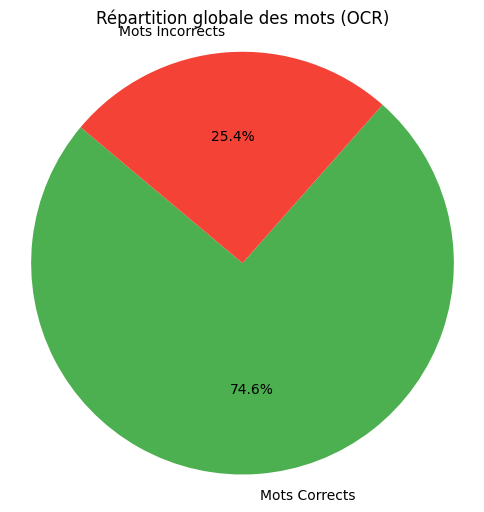

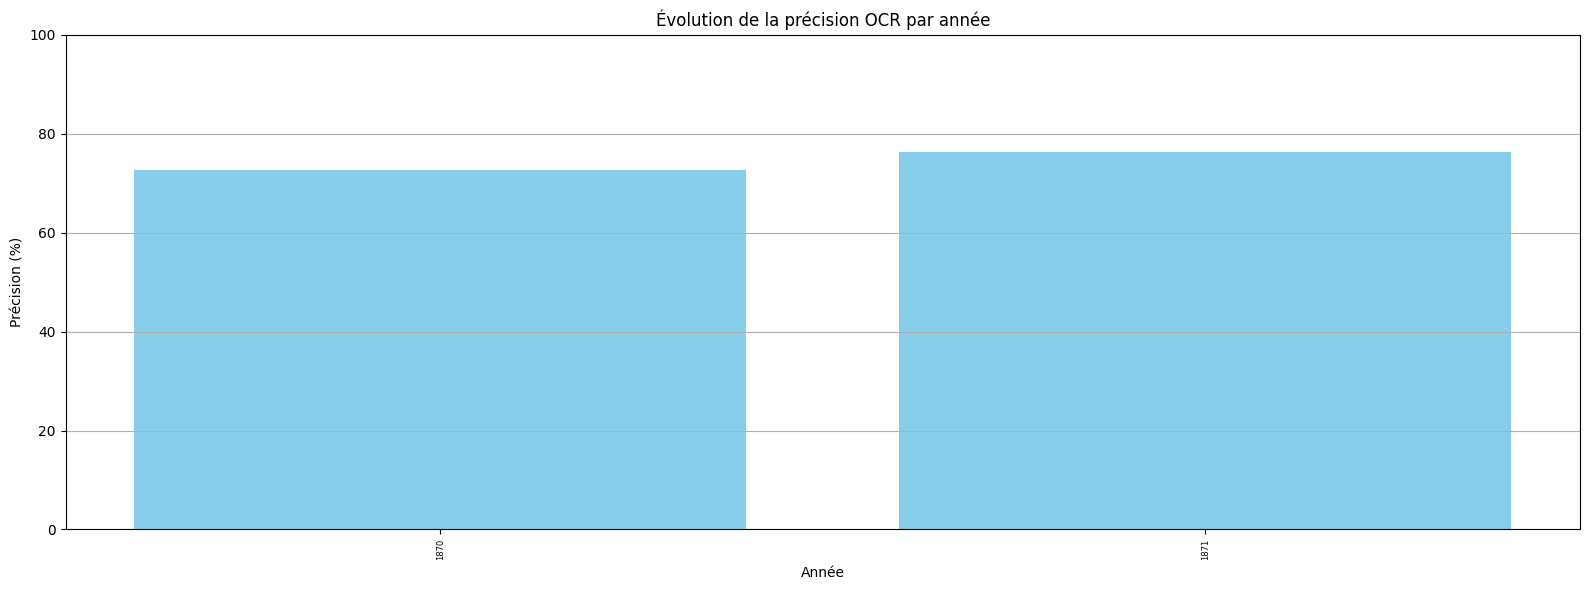

In [24]:
def afficher_précision(df, dico_fr, dico_med) :
    precision_df = calculer_precision_OCR(df, dico_fr, dico_med)
    print(precision_df.to_string(max_rows=1000000, max_cols=5))
    precision_df['Precision (%)'] = precision_df['Mots corrects'] / precision_df['Mots totaux'] * 100

    total_correct = precision_df.loc[precision_df['year'] == 'Total', 'Mots corrects'].values[0]
    total_words = precision_df.loc[precision_df['year'] == 'Total', 'Mots totaux'].values[0]
    total_incorrect = total_words - total_correct

    labels = ['Mots Corrects', 'Mots Incorrects']
    sizes = [total_correct, total_incorrect]
    colors = ['#4CAF50', '#F44336']

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Répartition globale des mots (OCR)')
    plt.axis('equal')  
    plt.show()

    precision_df_years_only = precision_df[precision_df['year'] != 'Total']

    plt.figure(figsize=(16,6))
    plt.bar(precision_df_years_only['year'], precision_df_years_only['Precision (%)'], color='skyblue')
    plt.title('Évolution de la précision OCR par année')
    plt.xlabel('Année')
    plt.ylabel('Précision (%)')
    plt.grid(axis='y')
    plt.xticks(rotation=90, fontsize=6)  # ← rotation 90° pour les années
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    return precision_df

df2 = afficher_précision(df1, dico_fr, dico_med)


100%|██████████| 337/337 [02:40<00:00,  2.10it/s]

    year  Mots corrects  Mots totaux
0   1870           1303         1316
1   1871           1420         1425
2  Total           2723         2741


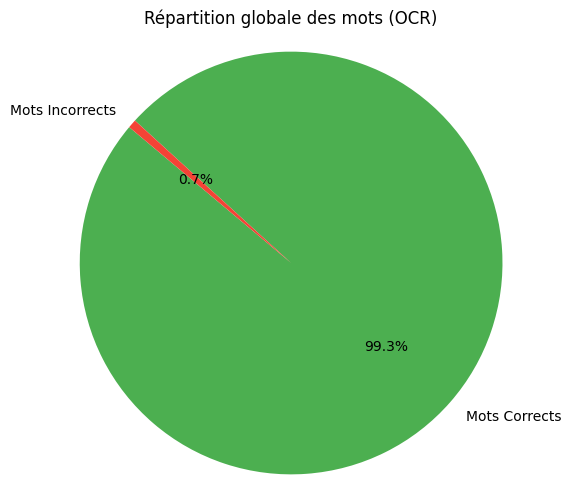

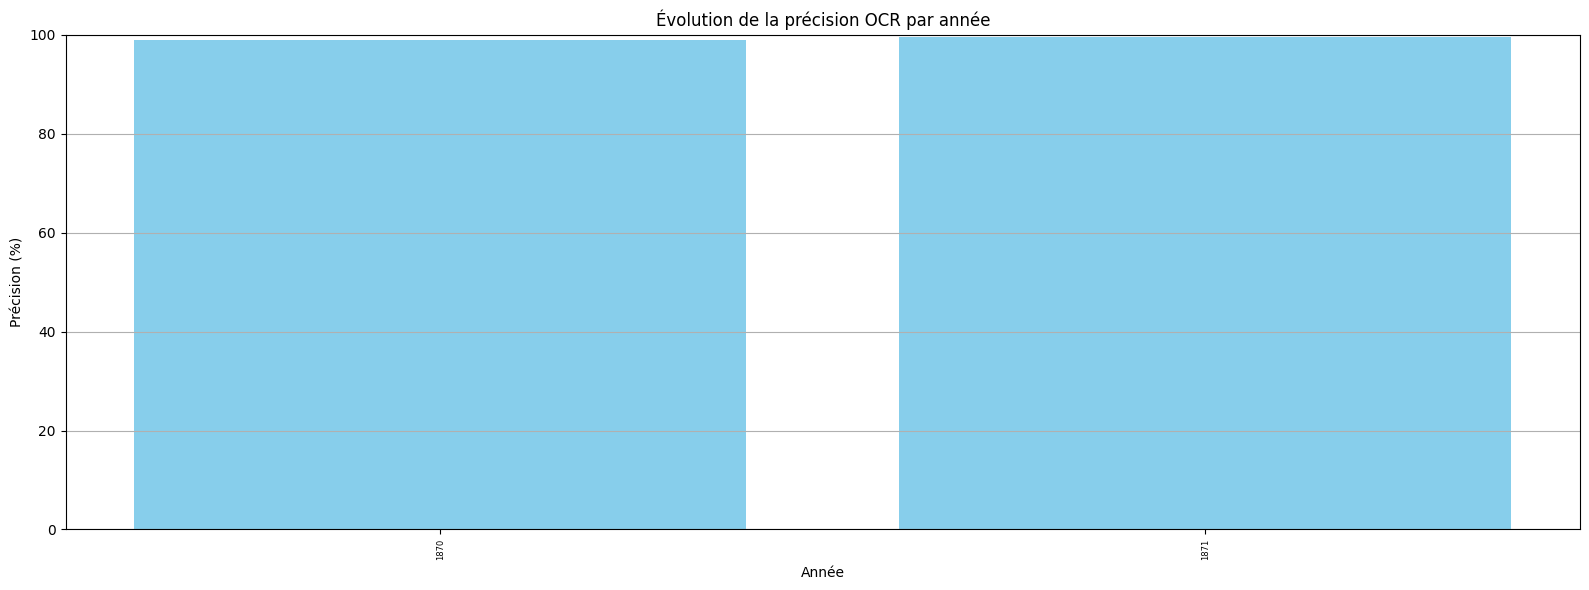

              Nom                Prénom                                                                                                                                                                                                                Sujet  year
0          ABADIE    Jean-Marie-Charles                                                                                                                                                                      etude sur la myopie stationnaire et progressive  1870
1         ANDRIEU              Alphonse                                                                                                                                                                    de anthrax de ses complications de son traitement  1870
2          ARCHER               Gabriel                                                                                                                                            etude sur don compliques de denudation de ex

In [25]:
def preprocess(text):
    text = unidecode.unidecode(text.lower()) 
    text = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ' -]", ' ', text)  
    return text.strip()

def correct_token(token, vocab, threshold=85):
    if token in vocab:
        return token
    match = rapidfuzz.process.extractOne(token, vocab, score_cutoff=threshold)
    if match:
        return match[0]  # match is (match_string, score, index)
    return token  

def correct_ocr_text(text, vocab):
    text = preprocess(text)
    tokens = text.split()
    corrected_tokens = [correct_token(t, vocab) for t in tokens]
    return ' '.join(corrected_tokens)

tqdm.tqdm.pandas()  
df3 = df1.copy()
df3['Sujet'] = df1['Sujet'].progress_apply(lambda x: correct_ocr_text(x, set(dico_fr) | set(dico_med)))

df4 = afficher_précision(df3, dico_fr, dico_med)

print(df3.to_string(max_rows=250, max_cols=210))




RECONNAISSANCE DU SEXE (DICTIONNAIRE DES PRENOMS) Dictionnaires pour pouvoir reconnaitre hommes femmes (dictionnaire de prénoms + rajouter ceux d'amelie puche) + remplir case sexe du csv + mettre case résolu vrai ou faux si la ligne a un prénom reconnu avec un sexe reconnu 
elle est résolu sinon il faut la résoudre
Reconnaitre hommes et femme et mettre infos dans csv + categorie pas sur ou prenoms double sexe ect sur lesquels il faudra faire des recherches specifiques et rentrer manuellement dans les csv ou 
Prénom mixte sans madame ou mademoiselle camille problématique recherche dans université paris cité
Marie est un piège car masculin a la fin du 19eme siècle
Marie compose peut être homme. donc tous les marie sont dans la categorie pas sur 

Nombre de femmmes vs nombre d'hommes total puis par annee et faire des graphes 

In [26]:
input_dir = input_dir = os.path.join(current_dir, '..', 'data', 'Dictionnaires')  # Relative path to 'lib/data/pdfs_en_images_png'

df_prenoms = pd.read_csv(os.path.join(input_dir, 'Prenoms.csv'), sep=";", header=None, names=["Prénom", "genre", "langue", "frequence"], encoding='ISO-8859-1')

df_prenoms['Prénom'] = df_prenoms['Prénom'].apply(remove_accents).str.lower()
dictionnaire_prenoms = dict(zip(df_prenoms['Prénom'], df_prenoms['genre']))

def detect_genre(prenom):
    if not isinstance(prenom, str):
        return "Inconnu"

    prenom_clean = remove_accents(prenom).lower()
    composants = re.split(r'[-\s]', prenom_clean)

    genres_detectes = set()
    for comp in composants:
        genre = dictionnaire_prenoms.get(comp)
        if genre:
            genres_detectes.update(genre.split(','))

    if not genres_detectes:
        return 'Inconnu'
    
    # Logique de priorité
    if genres_detectes == {'m'}:
        return 'm'
    elif genres_detectes == {'f'}:
        return 'f'
    elif 'm' in genres_detectes and 'f' not in genres_detectes:
        return 'm'
    elif 'f' in genres_detectes and 'm' not in genres_detectes:
        return 'f'
    elif 'm' in genres_detectes and 'f' in genres_detectes:
        return 'm'  # ← on priorise "m" dans les cas mixtes
    else:
        return 'Inconnu'



df3['Prénom'] = df3['Prénom'].apply(remove_accents).str.lower()

df3['genre'] = df3['Prénom'].apply(detect_genre)

print(df3.to_string(max_rows=250, max_cols=210))



              Nom                Prénom                                                                                                                                                                                                                Sujet  year    genre
0          ABADIE    jean-marie-charles                                                                                                                                                                      etude sur la myopie stationnaire et progressive  1870        m
1         ANDRIEU              alphonse                                                                                                                                                                    de anthrax de ses complications de son traitement  1870        m
2          ARCHER               gabriel                                                                                                                                            etude sur don com

 year  Inconnu  f   m
 1870       40  3 136
 1871       45  3 110
Total       85  6 246


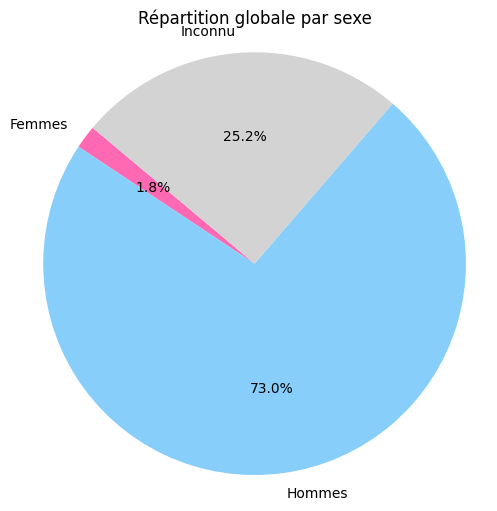

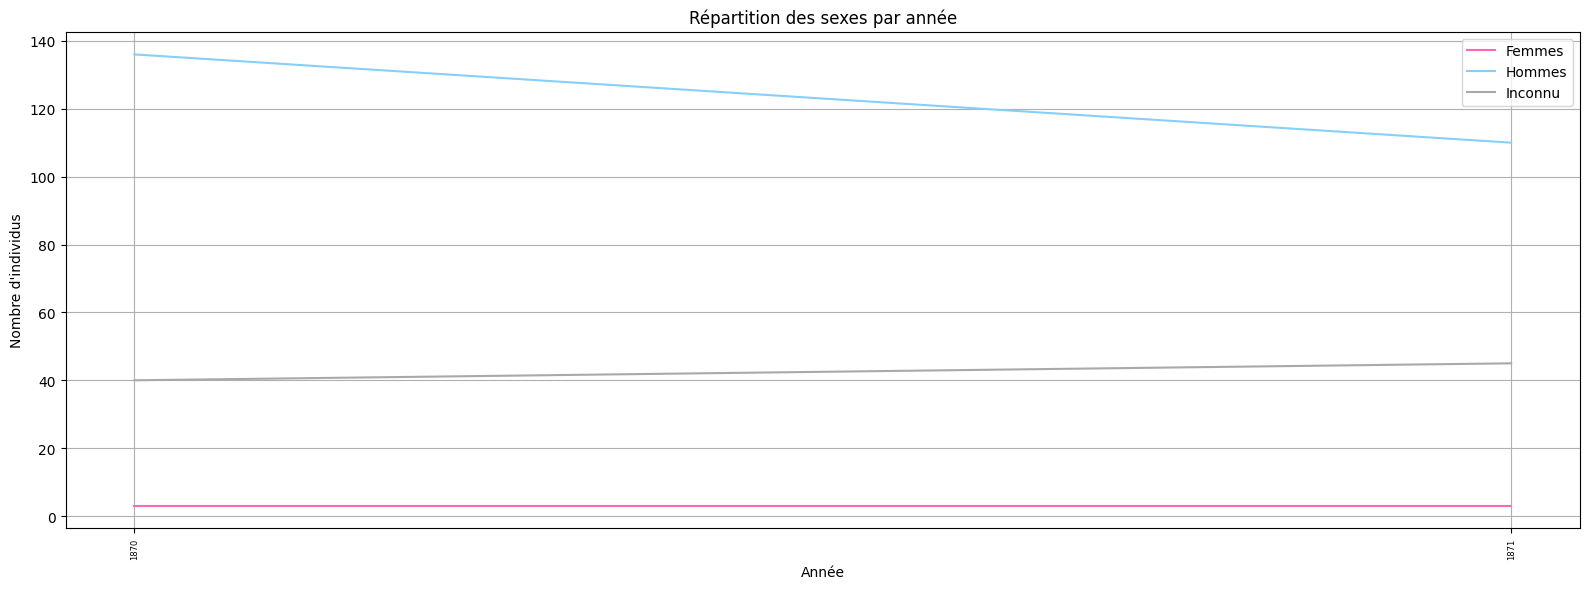

In [27]:
def calculer_genres_par_annee(df):
    # Compte des genres par année
    df_genre = df.groupby(['year', 'genre']).size().unstack(fill_value=0).reset_index()

    # Ajout de colonnes manquantes si nécessaire (ex: si 'm' ou 'f' absents dans certaines années)
    for genre in ['f', 'm', 'Inconnu']:
        if genre not in df_genre.columns:
            df_genre[genre] = 0

    # Calcul total tous genres
    total_row = pd.DataFrame({
        'year': ['Total'],
        'f': [df_genre['f'].sum()],
        'm': [df_genre['m'].sum()],
        'Inconnu': [df_genre['Inconnu'].sum()]
    })

    # Fusion avec les lignes par année
    df_genre = pd.concat([df_genre, total_row], ignore_index=True)

    return df_genre

def afficher_genres_par_annee(df):
    genre_df = calculer_genres_par_annee(df)

    # Affichage tableau
    print(genre_df.to_string(index=False))

    # Affichage du camembert global
    total = genre_df[genre_df['year'] == 'Total']
    sizes = [total['f'].values[0], total['m'].values[0], total['Inconnu'].values[0]]
    labels = ['Femmes', 'Hommes', 'Inconnu']
    colors = ['#FF69B4', '#87CEFA', '#D3D3D3']

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title("Répartition globale par sexe")
    plt.axis("equal")
    plt.show()

    # Affichage par année
    genre_df_years_only = genre_df[genre_df['year'] != 'Total']

    plt.figure(figsize=(16, 6))
    plt.plot(genre_df_years_only['year'], genre_df_years_only['f'], label='Femmes', color='#FF69B4')
    plt.plot(genre_df_years_only['year'], genre_df_years_only['m'], label='Hommes', color='#87CEFA')
    plt.plot(genre_df_years_only['year'], genre_df_years_only['Inconnu'], label='Inconnu', color='#A9A9A9')
    plt.legend()
    plt.title("Répartition des sexes par année")
    plt.xlabel("Année")
    plt.ylabel("Nombre d'individus")
    plt.xticks(rotation=90, fontsize=6)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return genre_df

df_genre = afficher_genres_par_annee(df3)


 year  f   m  Inconnu
 1870  3 136        0
 1871  3 110        0
Total  6 246        0


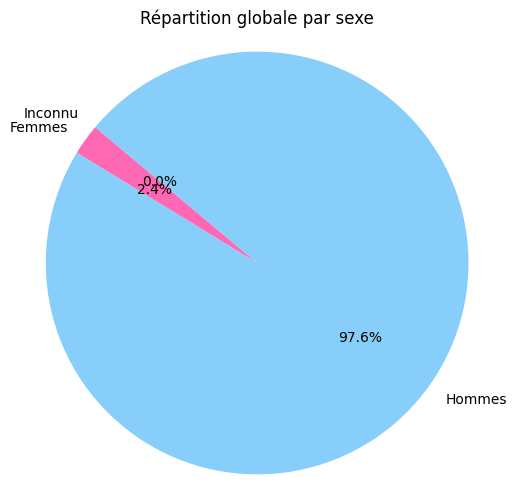

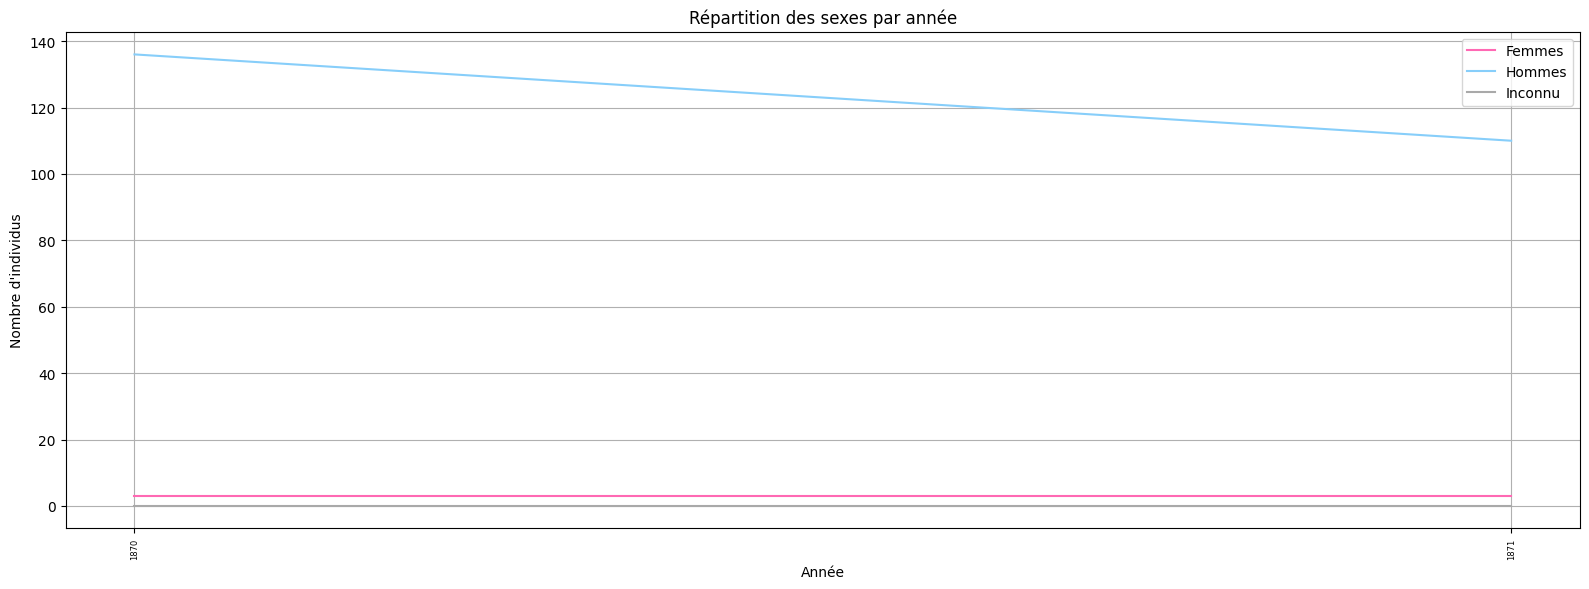

In [28]:
df3_filtré = df3[df3['genre'] != 'Inconnu'].copy()

df_genre = afficher_genres_par_annee(df3_filtré)

ANALYSE THEMATIQUE 